[Viewing LDA model results](#Visualization) <br>

In [1]:
!pip install pyLDAvis==2.1.2
import pandas as pd

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np

import nltk

import pyLDAvis.gensim
import pickle 
import pyLDAvis
print ('\n The verison of pyLDAvis is ',pyLDAvis.__version__)

from time import time

from pprint import pprint

from wordcloud import WordCloud
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

pd.set_option('display.max_rows',20)
nltk.download('wordnet')

     |████████████████████████████████| 1.6MB 5.3MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=e3b29fd169c138c3afeb08bc44e52426734848b40bcb3fd5129281112b2da94a
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable



 The verison of pyLDAvis is  2.1.2
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [2]:
df = pd.read_json(r'.json')
display(df.head())
data = df['content']
# Remove Emails, new line characters...
data = [re.sub('\S*@\S*\s?', '', i) for i in data]
data = [re.sub('\s+', ' ', i) for i in data]
data = [re.sub("\'", "", i) for i in data]

print(data[:1])

documents = pd.DataFrame(data, columns = ['content'])
documents['index'] = documents.index
print(len(documents))
documents[:3]

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: 15 I was wondering if anyone out there could enlighten me on this car I saw the other day. It was a 2-door sports car, looked to be from the late 60s/ early 70s. It was called a Bricklin. The doors were really small. In addition, the front bumper was separate from the rest of the body. This is all I know. If anyone can tellme a model name, engine specs, years of production, where this car is made, history, or whatever info you have on this funky looking car, please e-mail. Thanks, - IL ---- brought to you by your neighborhood Lerxst ---- ']
11314


,content,index
0,From: (wheres my thing) Subject: WHAT car is t...,0
1,From: (Guy Kuo) Subject: SI Clock Poll - Final...,1
2,From: (Thomas E Willis) Subject: PB questions....,2


In [3]:
# check statistics of number of words per content
display((documents.content.str.count(' ')+1).describe())
documents[(documents.content.str.count(' ')+1)==14]['content']

count    11314.000000
mean       284.285399
std        538.619529
min         13.000000
25%        106.000000
50%        174.000000
75%        290.000000
max      11808.000000
Name: content, dtype: float64

8545    From: (Mr. Someone) Subject: modem question Ar...
8602    From: (Hyoung Bok Min) Subject: subscribe Orga...
Name: content, dtype: object

## WordCloud of the content

'From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: 15 I was wondering if anyone out there could enlighten'

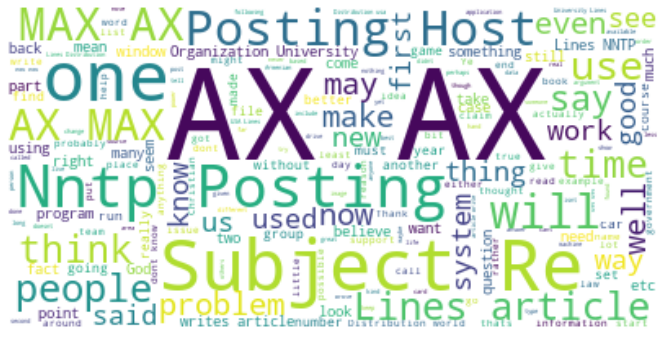

In [4]:
long_string = ','.join(list(documents['content'].values))
display(long_string[:200])

cloud = WordCloud(background_color = 'white', max_words = 5000, contour_width = 3, contour_color  ='steelblue')
cloud.generate(long_string)
# cloud.to_image()
plt.rcParams["figure.figsize"] = (20,6)
plt.imshow(cloud, interpolation='bilinear')

plt.axis("off")
plt.show()

### Data Preprocessing

In [7]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):    #simple_preprocess: Convert a document into a list of tokens
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [8]:
doc_sample = documents[documents['index'] == 8545].values[0][0]

print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['From:', '(Mr.', 'Someone)', 'Subject:', 'modem', 'question', 'Article-I.D.:', 'blue.9061', 'Organization:', 'pre-EE', 'Lines:', '2', 'art', '']


 tokenized and lemmatized document: 
['subject', 'modem', 'question', 'articl', 'blue', 'organ', 'line']


In [9]:
start = time()

processed_docs = documents['content'].map(preprocess)
end = time()
print('Model Fitting Time:', end - start)

processed_docs[:5]

Model Fitting Time: 31.257155418395996


0    [where, thing, subject, nntp, post, host, orga...
1    [subject, clock, poll, final, summari, final, ...
2    [thoma, willi, subject, question, organ, purdu...
3    [green, subject, weitek, organ, harri, system,...
4    [jonathan, mcdowel, subject, shuttl, launch, q...
Name: content, dtype: object

In [10]:
df = pd.DataFrame(processed_docs)
df['content2'] = df['content'].astype(str).str.replace('[','').replace(']','')
df.content2.values

array(["'where', 'thing', 'subject', 'nntp', 'post', 'host', 'organ', 'univers', 'maryland', 'colleg', 'park', 'line', 'wonder', 'enlighten', 'door', 'sport', 'look', 'late', 'earli', 'call', 'bricklin', 'door', 'small', 'addit', 'bumper', 'separ', 'rest', 'bodi', 'know', 'tellm', 'model', 'engin', 'spec', 'year', 'product', 'histori', 'info', 'funki', 'look', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']",
       "'subject', 'clock', 'poll', 'final', 'summari', 'final', 'clock', 'report', 'keyword', 'acceler', 'clock', 'upgrad', 'articl', 'shelley', 'qvfo', 'innc', 'organ', 'univers', 'washington', 'line', 'nntp', 'post', 'host', 'carson', 'washington', 'fair', 'number', 'brave', 'soul', 'upgrad', 'clock', 'oscil', 'share', 'experi', 'poll', 'send', 'brief', 'messag', 'detail', 'experi', 'procedur', 'speed', 'attain', 'rat', 'speed', 'card', 'adapt', 'heat', 'sink', 'hour', 'usag', 'floppi', 'disk', 'function', 'floppi', 'especi', 'request', 'summar', 'day', 'network', 'knowledg

# WordCloud of content after processing

"'where', 'thing', 'subject', 'nntp', 'post', 'host', 'organ', 'univers', 'maryland', 'colleg', 'park', 'line', 'wonder', 'enlighten', 'door', 'sport', 'look', 'late', 'earli', 'call', 'bricklin', 'doo"

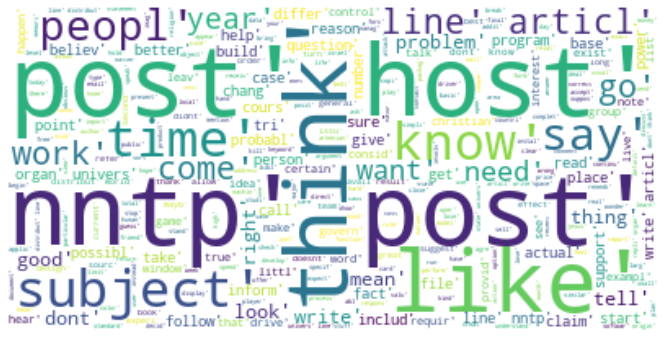

In [11]:
long_string2 = ','.join(list(df['content2'].values))
display(long_string2[:200])

cloud2 = WordCloud(background_color = 'white', max_words = 5000, contour_width = 3, contour_color  ='steelblue')
cloud2.generate(long_string2)

plt.imshow(cloud2, interpolation='bilinear')

plt.axis("off")
plt.show()

### Bag of words on the dataset

In [12]:
start = time()

dictionary = gensim.corpora.Dictionary(processed_docs)
end = time()
print('Model Fitting Time:', end - start)
print(dictionary)

Model Fitting Time: 1.4408302307128906
Dictionary(53319 unique tokens: ['addit', 'bodi', 'bricklin', 'bring', 'bumper']...)


In [13]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 5:
        break
print(str(dictionary[5])) 

0 addit
1 bodi
2 bricklin
3 bring
4 bumper
5 call
call


In [14]:
#no_below: less than no_below documents (absolute number)
#no_above: more than no_above documents (fraction of total corpus size, not absolute number).
#keep_n: keep only the first keep_n most frequent tokens (or keep all if None).

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=53319)  

In [15]:
# checking the frequency of the tokens within the dictionary
dictionary.save_as_text('gensimDictionary_filtered.txt')
df_check = pd.read_csv('gensimDictionary_filtered.txt', sep = '\t', names = ['word','frequency'], skiprows = 1)
display(df_check.sample(5))
df_check = df_check.sort_values(by = 'frequency')
display(df_check.head())
display(df_check[df_check.word =='broadcast'])
display(df_check.describe())
print('\n',dictionary)

,word,frequency
5206,handbook,31
4795,offenc,16
3804,barrel,42
4904,ctrl,25
1338,parti,272


,word,frequency
4726,zurich,15
5158,nathaniel,15
1396,terresteri,15
5209,tester,15
528,narrat,15


,word,frequency
3289,broadcast,98


,frequency
count,6218.000000
mean,119.936475
std,258.828718
min,15.000000
25%,23.000000
50%,42.000000
75%,109.000000
max,5352.000000



 Dictionary(6218 unique tokens: ['addit', 'bodi', 'bring', 'bumper', 'call']...)


### example to see what gensim.corpora.Dictionary and doc2bow do

In [16]:
example_dct = gensim.corpora.Dictionary(["abc def ghi".split(), 'def abb ghi'.split()])
print(example_dct)
example_dct.doc2bow(["abc", "def", "abe"], return_missing = True)

Dictionary(4 unique tokens: ['abc', 'def', 'ghi', 'abb'])


([(0, 1), (1, 1)], {'abe': 1})

### example ends

In [17]:
slicing = 0

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
globals()['bow_doc_%s' % slicing] = bow_corpus[slicing]

display(globals()['bow_doc_%s' % slicing])

for i in range(len(bow_doc_0)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_0[i][0], dictionary[bow_doc_0[i][0]], bow_doc_0[i][1]))

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 2),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 2),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 1),
 (33, 1)]

Word 0 ("addit") appears 1 time.
Word 1 ("bodi") appears 1 time.
Word 2 ("bring") appears 1 time.
Word 3 ("bumper") appears 1 time.
Word 4 ("call") appears 1 time.
Word 5 ("colleg") appears 1 time.
Word 6 ("door") appears 2 time.
Word 7 ("earli") appears 1 time.
Word 8 ("engin") appears 1 time.
Word 9 ("enlighten") appears 1 time.
Word 10 ("histori") appears 1 time.
Word 11 ("host") appears 1 time.
Word 12 ("info") appears 1 time.
Word 13 ("know") appears 1 time.
Word 14 ("late") appears 1 time.
Word 15 ("look") appears 2 time.
Word 16 ("mail") appears 1 time.
Word 17 ("maryland") appears 1 time.
Word 18 ("model") appears 1 time.
Word 19 ("neighborhood") appears 1 time.
Word 20 ("nntp") appears 1 time.
Word 21 ("park") appears 1 time.
Word 22 ("product") appears 1 time.
Word 23 ("rest") appears 1 time.
Word 24 ("separ") appears 1 time.
Word 25 ("small") appears 1 time.
Word 26 ("spec") appears 1 time.
Word 27 ("sport") appears 1 time.
Word 28 ("thank") appears 1 time.
Word 29 ("thing")

In [18]:
[[(dictionary[id], freq) for id, freq in cp] for cp in bow_corpus[:1]]

[[('addit', 1),
  ('bodi', 1),
  ('bring', 1),
  ('bumper', 1),
  ('call', 1),
  ('colleg', 1),
  ('door', 2),
  ('earli', 1),
  ('engin', 1),
  ('enlighten', 1),
  ('histori', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('look', 2),
  ('mail', 1),
  ('maryland', 1),
  ('model', 1),
  ('neighborhood', 1),
  ('nntp', 1),
  ('park', 1),
  ('product', 1),
  ('rest', 1),
  ('separ', 1),
  ('small', 1),
  ('spec', 1),
  ('sport', 1),
  ('thank', 1),
  ('thing', 1),
  ('univers', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

### TF-IDF

In [19]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [20]:
for doc in corpus_tfidf:
    print(doc)
    break

[(0, 0.15769781404371838), (1, 0.16011793307988162), (2, 0.143276889401385), (3, 0.2726386060429861), (4, 0.10911833438120251), (5, 0.14468804436539506), (6, 0.3713819361555031), (7, 0.16163192319909164), (8, 0.11824591099295646), (9, 0.25131305432918016), (10, 0.15699533987144274), (11, 0.039975798106812184), (12, 0.1338562683394189), (13, 0.050860649524620626), (14, 0.17018295779311815), (15, 0.15410090234874596), (16, 0.0981872869037894), (17, 0.22263644642695282), (18, 0.15472653851796414), (19, 0.2675328751811592), (20, 0.040691507273713526), (21, 0.17694656208207923), (22, 0.14182238871355926), (23, 0.1523507426198676), (24, 0.17336139676655146), (25, 0.13809769235626343), (26, 0.20212476651644576), (27, 0.18401320990684983), (28, 0.08043547044347478), (29, 0.0799108406866864), (30, 0.04238106804731305), (31, 0.29674036887567534), (32, 0.13089134123614612), (33, 0.0803209232228464)]


### LDA of using Bag of Words

In [21]:
start = time()
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=7, id2word=dictionary, passes=2 
                    , random_state = 10, per_word_topics = True, chunksize = 200)
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 24.340939044952393


In [22]:
display(processed_docs[8545])
pprint(lda_model[bow_corpus[8545]])

['subject', 'modem', 'question', 'articl', 'blue', 'organ', 'line']

([(0, 0.028625423),
  (1, 0.028610203),
  (2, 0.028663818),
  (3, 0.028675795),
  (4, 0.82792646),
  (5, 0.02861545),
  (6, 0.02888285)],
 [(37, [4]), (136, [4]), (1406, [4]), (2128, [4])],
 [(37, [(4, 0.9991167)]),
  (136, [(4, 0.9991979)]),
  (1406, [(4, 0.9999999)]),
  (2128, [(4, 0.9985238)])])


### Performance evaluation using LDA Bag of Words model

In [23]:
for index, score in sorted(lda_model[bow_corpus[8545]][0], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.8279284238815308	 
Topic: 0.017*"drive" + 0.013*"host" + 0.012*"nntp" + 0.012*"univers" + 0.008*"card" + 0.008*"articl" + 0.008*"thank" + 0.007*"need" + 0.007*"distribut" + 0.007*"know"

Score: 0.028880855068564415	 
Topic: 0.018*"team" + 0.017*"game" + 0.013*"year" + 0.011*"play" + 0.009*"univers" + 0.009*"articl" + 0.009*"hockey" + 0.009*"player" + 0.007*"host" + 0.007*"nntp"

Score: 0.028675789013504982	 
Topic: 0.013*"dont" + 0.013*"like" + 0.011*"think" + 0.011*"articl" + 0.010*"go" + 0.009*"know" + 0.009*"time" + 0.008*"peopl" + 0.007*"thing" + 0.007*"say"

Score: 0.028663814067840576	 
Topic: 0.011*"peopl" + 0.010*"christian" + 0.009*"believ" + 0.009*"think" + 0.008*"know" + 0.007*"say" + 0.007*"articl" + 0.006*"jesus" + 0.006*"evid" + 0.006*"exist"

Score: 0.02862541936337948	 
Topic: 0.020*"window" + 0.019*"file" + 0.014*"program" + 0.007*"entri" + 0.007*"version" + 0.007*"imag" + 0.006*"graphic" + 0.006*"sourc" + 0.006*"mail" + 0.006*"avail"

Score: 0.02861544862389

In [24]:
# for idx, topic in lda_model.print_topics(-1):
#     print('Topic: {} \nWords: {}'.format(idx, topic))

In [25]:
pd.DataFrame([item[1].split('+') for item in lda_model.print_topics(-1)]).T

,0,1,2,3,4,5,6
0,"0.020*""window""","0.010*""govern""","0.011*""peopl""","0.013*""dont""","0.017*""drive""","0.016*""space""","0.018*""team"""
1,"0.019*""file""","0.010*""peopl""","0.010*""christian""","0.013*""like""","0.013*""host""","0.008*""research""","0.017*""game"""
2,"0.014*""program""","0.009*""state""","0.009*""believ""","0.011*""think""","0.012*""nntp""","0.007*""year""","0.013*""year"""
3,"0.007*""entri""","0.008*""right""","0.009*""think""","0.011*""articl""","0.012*""univers""","0.007*""nasa""","0.011*""play"""
4,"0.007*""version""","0.007*""public""","0.008*""know""","0.010*""go""","0.008*""card""","0.006*""technolog""","0.009*""univers"""
5,"0.007*""imag""","0.007*""encrypt""","0.007*""say""","0.009*""know""","0.008*""articl""","0.006*""articl""","0.009*""articl"""
6,"0.006*""graphic""","0.007*""israel""","0.007*""articl""","0.009*""time""","0.008*""thank""","0.006*""univers""","0.009*""hockey"""
7,"0.006*""sourc""","0.006*""secur""","0.006*""jesus""","0.008*""peopl""","0.007*""need""","0.006*""orbit""","0.009*""player"""
8,"0.006*""mail""","0.005*""isra""","0.006*""evid""","0.007*""thing""","0.007*""distribut""","0.006*""develop""","0.007*""host"""
9,"0.006*""avail""","0.005*""clipper""","0.006*""exist""","0.007*""say""","0.007*""know""","0.006*""earth""","0.007*""nntp"""


In [26]:
print(gensim.models.CoherenceModel(model = lda_model, texts =processed_docs , dictionary = dictionary, coherence = 'c_v').get_coherence())

0.5413797126990515


Cool! Can you distinguish different topics using the words in each topic and their corresponding weights?

### LDA of using TF-IDF

In [27]:
start = time()
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=7, id2word=dictionary, passes=2
                    , random_state = 10, per_word_topics = True, chunksize = 200)
end = time()
print('Model Fitting Time:', end - start)
print(gensim.models.CoherenceModel(model = lda_model_tfidf, texts =processed_docs , dictionary = dictionary, coherence = 'c_v').get_coherence())

Model Fitting Time: 22.367103338241577
0.5133953148855064


In [28]:
# try using chucksize = 100
start = time()
lda_model_tfidf_100chunksize = gensim.models.LdaMulticore(corpus_tfidf, num_topics=7, id2word=dictionary
                                                          #, alpha = 0.2, eta = 0.4, workers=8
                            , passes=2,per_word_topics = True, random_state = 10, chunksize = 100)
end = time()
print('Model Fitting Time:', end - start)
print(gensim.models.CoherenceModel(model = lda_model_tfidf_100chunksize, texts =processed_docs , dictionary = dictionary, coherence = 'c_v').get_coherence())

Model Fitting Time: 22.659837245941162
0.4832338366657566


###### The Coherence scores of chunksize = 100 and 200 are similar

** **
## Optimizing the model by picking the optimal value of alpha, eta & topic number
** **

In [30]:
start_topics = time()
model_list, coherence_values, pairs = compute_coherence(
    corpus=corpus_tfidf
    ,dictionary=dictionary
    , seed=10, texts=processed_docs
    , alpha_start=2, alpha_limit=7, alpha_step=2
    ,eta_start=20, eta_limit=61, eta_step=20
    , topic_start=5, topic_limit=10, topic_step=2)

end_topics = time()
print('Fitting Time:', end_topics - start_topics)

alpha/eta/topic:  2 /  20 /  5
LdaModel(num_terms=6218, num_topics=5, decay=0.5, chunksize=200) 0.4759326009214135 

alpha/eta/topic:  2 /  20 /  7
LdaModel(num_terms=6218, num_topics=7, decay=0.5, chunksize=200) 0.504969476349857 

alpha/eta/topic:  2 /  20 /  9
LdaModel(num_terms=6218, num_topics=9, decay=0.5, chunksize=200) 0.5622214164367583 

alpha/eta/topic:  2 /  40 /  5
LdaModel(num_terms=6218, num_topics=5, decay=0.5, chunksize=200) 0.4580220660510889 

alpha/eta/topic:  2 /  40 /  7
LdaModel(num_terms=6218, num_topics=7, decay=0.5, chunksize=200) 0.5848693691890868 

alpha/eta/topic:  2 /  40 /  9
LdaModel(num_terms=6218, num_topics=9, decay=0.5, chunksize=200) 0.5782818569354463 

alpha/eta/topic:  2 /  60 /  5
LdaModel(num_terms=6218, num_topics=5, decay=0.5, chunksize=200) 0.4973980918831108 

alpha/eta/topic:  2 /  60 /  7
LdaModel(num_terms=6218, num_topics=7, decay=0.5, chunksize=200) 0.5849517163099431 

alpha/eta/topic:  2 /  60 /  9
LdaModel(num_terms=6218, num_topic

In [31]:
output = pd.DataFrame(pairs,coherence_values)
output['pair'] = output[0].map(str) + '/' + output[1].map(str) + '/' + output[2].map(str)
output['coherence_values'] = output.index

,0,1,2,pair,coherence_values
0.603263,2,60,9,2/60/9,0.603263
0.584952,2,60,7,2/60/7,0.584952
0.584869,2,40,7,2/40/7,0.584869
0.578282,2,40,9,2/40/9,0.578282
0.562221,2,20,9,2/20/9,0.562221


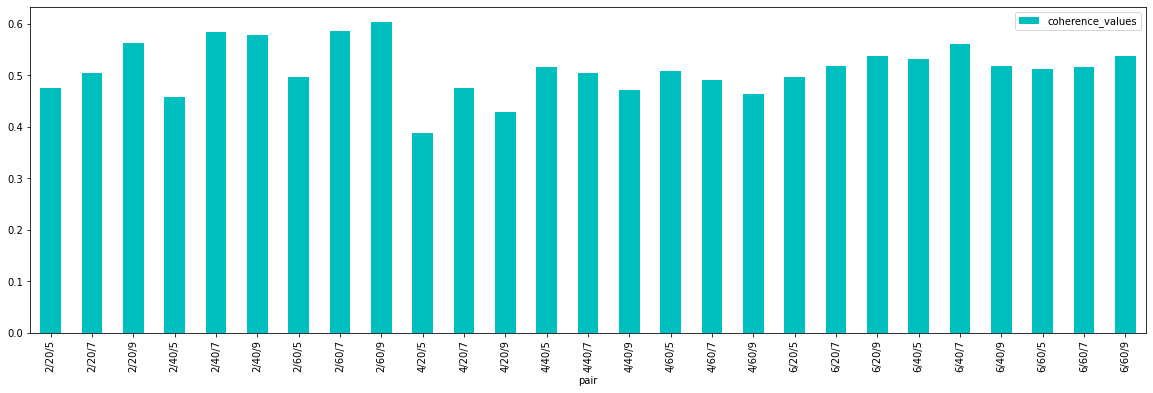

In [32]:
display(output.sort_values('coherence_values', ascending = False).head())
output.sort_values([0,1], ascending = True).plot(kind = 'bar', x = 'pair', y = 'coherence_values', figsize = (20,6), color = 'c')

** **
#### Let's pick alpha = 0.2, eta = 0.6 and 9 topics to tune our LDA model <a class="anchor\" id="results"></a>
** **

In [33]:
start = time()
lda_model_tfidf_best = gensim.models.LdaMulticore(corpus_tfidf, num_topics= 9
                          , id2word=dictionary, passes=10
                          ,per_word_topics = False
                          , alpha = 0.2, eta = 0.6
                          , random_state = 10, chunksize = 200)
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 114.08863615989685


In [37]:
print(gensim.models.CoherenceModel(model = lda_model_tfidf_best, texts =processed_docs , dictionary = dictionary, coherence = 'c_v').get_coherence())

0.5971715359421377


In [34]:
display(documents[documents.index ==8545].content.values)
display(processed_docs[8545])

print(lda_model_tfidf_best[bow_corpus[8545]]) # it's printing the probability of those 13 topics of content 8545
print(lda_model_tfidf_best[corpus_tfidf[8545]])

array(['From: (Mr. Someone) Subject: modem question Article-I.D.: blue.9061 Organization: pre-EE Lines: 2 art '],
      dtype=object)

['subject', 'modem', 'question', 'articl', 'blue', 'organ', 'line']

[(0, 0.03458501), (1, 0.034597535), (2, 0.034578666), (3, 0.035472047), (4, 0.71988326), (5, 0.034579847), (6, 0.036697783), (7, 0.034578666), (8, 0.035027165)]
[(0, 0.056278374), (1, 0.056301508), (2, 0.056277998), (3, 0.057413235), (4, 0.54286975), (5, 0.05628113), (6, 0.061721485), (7, 0.056277998), (8, 0.056578554)]


In [39]:
pd.DataFrame([item[1].split('+') for item in lda_model_tfidf_best.print_topics(-1)]).T

# Top 10 keywords that contribute to topic 0 are : gordon, bank, chastiti, shame, etc... 
# the weights reflect how important a keyword is to that topic

,0,1,2,3,4,5,6,7,8
0,"0.007*""gordon""","0.012*""encrypt""","0.000*""thier""","0.003*""christian""","0.006*""window""","0.002*""cliff""","0.008*""team""","0.000*""thier""","0.003*""israel"""
1,"0.006*""bank""","0.009*""clipper""","0.000*""decim""","0.002*""peopl""","0.004*""card""","0.001*""sunris""","0.008*""game""","0.000*""decim""","0.003*""govern"""
2,"0.003*""chastiti""","0.007*""chip""","0.000*""dash""","0.002*""think""","0.004*""thank""","0.001*""sunset""","0.005*""player""","0.000*""tablet""","0.003*""peopl"""
3,"0.003*""shame""","0.006*""escrow""","0.000*""tablet""","0.002*""bike""","0.004*""file""","0.001*""dakota""","0.005*""hockey""","0.000*""dash""","0.003*""isra"""
4,"0.003*""surrend""","0.005*""key""","0.000*""wallac""","0.002*""space""","0.003*""drive""","0.001*""roman""","0.004*""play""","0.000*""wallac""","0.002*""clinton"""
5,"0.003*""intellect""","0.004*""crypto""","0.000*""dutch""","0.002*""jesus""","0.003*""driver""","0.001*""south""","0.003*""year""","0.000*""dutch""","0.002*""state"""
6,"0.002*""skeptic""","0.004*""secur""","0.000*""ucalgari""","0.002*""articl""","0.003*""mail""","0.000*""shoe""","0.003*""score""","0.000*""ucalgari""","0.002*""right"""
7,"0.001*""soon""","0.004*""algorithm""","0.000*""eugen""","0.002*""like""","0.003*""sale""","0.000*""repli""","0.003*""basebal""","0.000*""eugen""","0.002*""gun"""
8,"0.001*""pittsburgh""","0.003*""secret""","0.000*""unlock""","0.002*""say""","0.003*""need""","0.000*""distribut""","0.003*""playoff""","0.000*""unlock""","0.002*""weapon"""
9,"0.001*""univ""","0.002*""wiretap""","0.000*""salmon""","0.002*""dont""","0.003*""graphic""","0.000*""univers""","0.003*""season""","0.000*""salmon""","0.002*""kill"""


### Performance evaluation by using LDA TF-IDF model

In [40]:
for index, score in sorted(lda_model_tfidf_best[bow_corpus[8545]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf_best.print_topic(index, 10)))


Score: 0.7199782729148865	 
Topic: 0.006*"window" + 0.004*"card" + 0.004*"thank" + 0.004*"file" + 0.003*"drive" + 0.003*"driver" + 0.003*"mail" + 0.003*"sale" + 0.003*"need" + 0.003*"graphic"

Score: 0.03660368546843529	 
Topic: 0.008*"team" + 0.008*"game" + 0.005*"player" + 0.005*"hockey" + 0.004*"play" + 0.003*"year" + 0.003*"score" + 0.003*"basebal" + 0.003*"playoff" + 0.003*"season"

Score: 0.035471536219120026	 
Topic: 0.003*"christian" + 0.002*"peopl" + 0.002*"think" + 0.002*"bike" + 0.002*"space" + 0.002*"jesus" + 0.002*"articl" + 0.002*"like" + 0.002*"say" + 0.002*"dont"

Score: 0.035026878118515015	 
Topic: 0.003*"israel" + 0.003*"govern" + 0.003*"peopl" + 0.003*"isra" + 0.002*"clinton" + 0.002*"state" + 0.002*"right" + 0.002*"gun" + 0.002*"weapon" + 0.002*"kill"

Score: 0.03459750860929489	 
Topic: 0.012*"encrypt" + 0.009*"clipper" + 0.007*"chip" + 0.006*"escrow" + 0.005*"key" + 0.004*"crypto" + 0.004*"secur" + 0.004*"algorithm" + 0.003*"secret" + 0.002*"wiretap"

Score: 0.0

# Visualizing the topics  <a class="anchor\" id="Visualization"></a>

In [43]:
pyLDAvis.enable_notebook()

start2 = time()
pyLDAvis_output = pyLDAvis.gensim.prepare(lda_model_tfidf_best, corpus_tfidf, dictionary, sort_topics = False, mds = 'mmds')
end2 = time()
print('Model Fitting Time:', end2 - start2)
print(pyLDAvis_output.topic_order)

Model Fitting Time: 12.151206016540527
[1, 2, 3, 4, 5, 6, 7, 8, 9]


In [44]:
pyLDAvis_output

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.039643 -0.019727       1        1   2.755266
1      0.080440 -0.018097       2        1   4.354021
2      0.033796 -0.017067       3        1   2.567339
3     -0.088329 -0.019071       4        1  31.149499
4     -0.106820  0.102510       5        1  26.003708
5      0.033762 -0.017870       6        1   2.605853
6      0.029675  0.096180       7        1  10.098847
7      0.033796 -0.017067       8        1   2.567339
8     -0.055963 -0.089791       9        1  17.898127, topic_info=         Term        Freq       Total Category  logprob  loglift
692      team   61.000000   61.000000  Default  30.0000  30.0000
1437  encrypt   38.000000   38.000000  Default  29.0000  29.0000
162      chip   57.000000   57.000000  Default  28.0000  28.0000
1175     game   69.000000   69.000000  Default  27.0000  27.0000
1025   window  103.000000  103.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
295       say   19.291950   77.085284   Topic9  -6.4324   0.3352
117      like   18.223777  103.274406   Topic9  -6.4894  -0.0142
154      time   17.515761   84.830035   Topic9  -6.5290   0.1429
106        go   16.814424   75.856570   Topic9  -6.5699   0.2139
1407   nation   16.101380   44.129556   Topic9  -6.6132   0.7122

[543 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1264      4  0.131302     acn
1264      5  0.131302     acn
1264      7  0.131302     acn
1264      9  0.393907     acn
82        4  0.142740  advanc
...     ...       ...     ...
33        4  0.362136    year
33        5  0.137362    year
33        7  0.299699    year
33        9  0.187312    year
3103      4  0.783372  zoolog

[1110 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9])

In [45]:
pyLDAvis.save_html(pyLDAvis_output, 'lda.html')

##### WordCloud of the best LDA model by topic level

{'gordon': 0.0066268775, 'bank': 0.005653917, 'chastiti': 0.002872466, 'shame': 0.0028406766, 'surrend': 0.0028390365, 'intellect': 0.002814817, 'skeptic': 0.0023379202, 'soon': 0.0014665812, 'pittsburgh': 0.0013822482, 'univ': 0.0013802871, 'migrain': 0.00078430906, 'mississippi': 0.0007410218, 'nerv': 0.00065090595, 'river': 0.00046326924, 'scienc': 0.00045775, 'pitt': 0.00039470874, 'ray': 0.00035874793, 'jess': 0.00032441426, 'drop': 0.00029792645, 'blood': 0.00029507582, 'legisl': 0.00029265624, 'supplement': 0.00029021976, 'stimul': 0.00028801794, 'vomit': 0.00028770367, 'repli': 0.0002876353, 'faint': 0.00027844904, 'rebound': 0.00027547666, 'medic': 0.00027301564, 'diagnosi': 0.00026299767, 'glen': 0.00025730985, 'pressur': 0.0002563388, 'regain': 0.00025097543, 'divert': 0.00024711047, 'spite': 0.00024673785, 'rout': 0.00024141197, 'renew': 0.00023882887, 'contribut': 0.00023389651, 'surgeon': 0.00023327532, 'slow': 0.0002329432, 'brian': 0.00023284639, 'partner': 0.0002327426

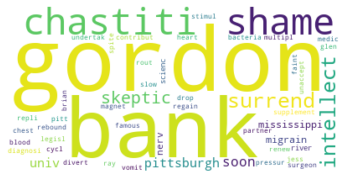



{'encrypt': 0.011795538, 'clipper': 0.008983532, 'chip': 0.007049027, 'escrow': 0.0061562713, 'key': 0.0048029395, 'crypto': 0.00403617, 'secur': 0.0039855614, 'algorithm': 0.0035959878, 'secret': 0.0028521263, 'wiretap': 0.002260167, 'templeton': 0.002242272, 'ripem': 0.0021931455, 'decrypt': 0.0021539708, 'tap': 0.0019910566, 'tempest': 0.0019867248, 'clarinet': 0.0019848451, 'sternlight': 0.0019664108, 'phone': 0.0019385848, 'intercon': 0.0019370682, 'classifi': 0.0017788556, 'brad': 0.0017527243, 'vesselin': 0.0017436875, 'govern': 0.0017391626, 'privaci': 0.00170868, 'announc': 0.0016985381, 'qualcomm': 0.0016894775, 'hous': 0.0016635084, 'communic': 0.0016410215, 'amanda': 0.0015509895, 'walker': 0.0014777306, 'agenc': 0.0014688802, 'trust': 0.0014615647, 'warrant': 0.0014614953, 'hamburg': 0.0014460621, 'scheme': 0.0014445262, 'nist': 0.0014345823, 'toal': 0.0013764182, 'public': 0.0013106869, 'cryptographi': 0.0013039445, 'code': 0.0012950454, 'bontchev': 0.0012820276, 'ciphe

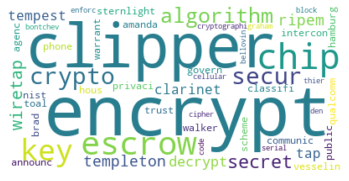



{'thier': 0.00016796727, 'decim': 0.0001675604, 'dash': 0.00016752465, 'tablet': 0.00016752077, 'wallac': 0.00016744016, 'dutch': 0.0001671397, 'ucalgari': 0.00016626049, 'eugen': 0.00016605173, 'unlock': 0.00016586573, 'salmon': 0.00016575986, 'rodney': 0.00016547437, 'bridg': 0.00016544928, 'passion': 0.00016543997, 'inhal': 0.00016540673, 'talon': 0.00016540663, 'livingston': 0.0001651588, 'dens': 0.000165082, 'deepli': 0.00016506259, 'parker': 0.00016501987, 'euro': 0.00016496285, 'anthoni': 0.0001649359, 'drum': 0.00016482569, 'southwestern': 0.00016475217, 'unfair': 0.00016470495, 'acn': 0.00016459778, 'berri': 0.00016459142, 'beginn': 0.00016458608, 'vladimir': 0.0001645347, 'buddi': 0.00016452777, 'flip': 0.0001644715, 'dictat': 0.00016433549, 'ward': 0.0001641946, 'mississippi': 0.00016417158, 'bernoulli': 0.00016416011, 'jackson': 0.00016412586, 'lay': 0.00016408772, 'vega': 0.00016407899, 'nigel': 0.00016407653, 'lobbi': 0.00016406078, 'walter': 0.00016402734, 'hunter': 0.

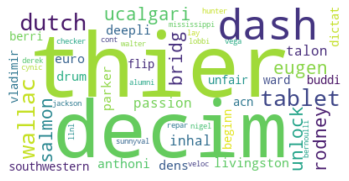



{'christian': 0.0025294065, 'peopl': 0.0022854186, 'think': 0.0021363467, 'bike': 0.002064314, 'space': 0.0019915437, 'jesus': 0.0019435412, 'articl': 0.0019410222, 'like': 0.001936003, 'say': 0.0018408389, 'dont': 0.0018114024, 'thing': 0.0018072918, 'believ': 0.0017179792, 'know': 0.0017160388, 'time': 0.0016874954, 'good': 0.0015808739, 'question': 0.0014915655, 'go': 0.0014830137, 'bibl': 0.0014770342, 'univers': 0.0014207402, 'come': 0.0014093406, 'year': 0.0014000125, 'car': 0.0013877562, 'church': 0.0013802855, 'atheist': 0.0013779132, 'mean': 0.0013683767, 'john': 0.0013585755, 'group': 0.0013514161, 'love': 0.0013386516, 'work': 0.0013223989, 'engin': 0.001312691, 'moral': 0.00130332, 'tell': 0.0012976691, 'evid': 0.0012893389, 'orbit': 0.001272675, 'reason': 0.0012644891, 'live': 0.0012456856, 'want': 0.0012421794, 'religion': 0.00123557, 'nntp': 0.0012240893, 'look': 0.0012231794, 'host': 0.0012114949, 'read': 0.0012047795, 'exist': 0.0011995053, 'distribut': 0.0011899943,

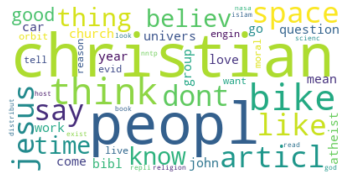



{'window': 0.0055890954, 'card': 0.0038832456, 'thank': 0.0037739882, 'file': 0.0035048176, 'drive': 0.0034190605, 'driver': 0.003297308, 'mail': 0.0030076054, 'sale': 0.002924002, 'need': 0.002794625, 'graphic': 0.0027696968, 'univers': 0.0025678312, 'problem': 0.0025632193, 'video': 0.0025182187, 'email': 0.002513894, 'nntp': 0.002411481, 'program': 0.0024055296, 'host': 0.0023873013, 'work': 0.0023847672, 'version': 0.0023791518, 'softwar': 0.0023334182, 'help': 0.0022578356, 'color': 0.0022485259, 'distribut': 0.0022032463, 'know': 0.002198433, 'disk': 0.002196896, 'advanc': 0.0021834327, 'repli': 0.0021815335, 'look': 0.002100004, 'mous': 0.0020461446, 'like': 0.002024286, 'want': 0.0020022995, 'monitor': 0.0019378735, 'machin': 0.0019115041, 'number': 0.0018467366, 'appreci': 0.0018311145, 'instal': 0.00182629, 'control': 0.0018162037, 'packag': 0.001802207, 'price': 0.0018002383, 'chip': 0.0017777742, 'memori': 0.0017687052, 'data': 0.0017679862, 'info': 0.001742987, 'scsi': 0

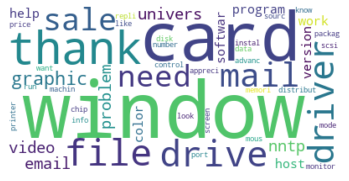



{'cliff': 0.0015477185, 'sunris': 0.0010234255, 'sunset': 0.0008900188, 'dakota': 0.000724714, 'roman': 0.00069943507, 'south': 0.0005545795, 'shoe': 0.00038824786, 'repli': 0.0002888764, 'distribut': 0.0002793966, 'univers': 0.00023168047, 'mack': 0.00022478575, 'desert': 0.00021446512, 'wallpap': 0.00021256624, 'purdu': 0.00019083904, 'astro': 0.0001870074, 'daylight': 0.00018690272, 'ucsc': 0.00018560544, 'upto': 0.00018408574, 'joseph': 0.0001791883, 'orbit': 0.00017742124, 'length': 0.0001765289, 'nada': 0.00017523447, 'baltimor': 0.00017418707, 'zoolog': 0.00017397663, 'henri': 0.00017386618, 'uuencod': 0.00017362859, 'algorithm': 0.00017124246, 'spencer': 0.00017113205, 'hassl': 0.00017077148, 'stockholm': 0.00017039718, 'easiest': 0.00017015626, 'earliest': 0.0001701396, 'deriv': 0.00016955391, 'versa': 0.00016933793, 'border': 0.00016890868, 'vice': 0.00016872221, 'synchron': 0.00016833986, 'thier': 0.0001669165, 'decim': 0.00016650348, 'dash': 0.0001664798, 'tablet': 0.0001

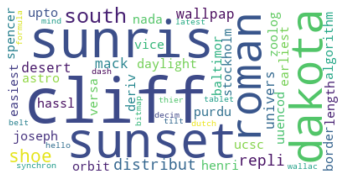



{'team': 0.008092896, 'game': 0.007573486, 'player': 0.005076808, 'hockey': 0.0045247376, 'play': 0.0041085454, 'year': 0.0034843604, 'score': 0.0032270427, 'basebal': 0.0031993035, 'playoff': 0.0031714845, 'season': 0.0028747949, 'wing': 0.0026174523, 'toronto': 0.002433025, 'leagu': 0.0022907371, 'goal': 0.002017624, 'leaf': 0.0019682525, 'cub': 0.0018931606, 'coach': 0.0018928371, 'stat': 0.0018899485, 'espn': 0.0018260687, 'win': 0.0017772288, 'detroit': 0.0017754729, 'fan': 0.00177399, 'lose': 0.0017693314, 'coverag': 0.0017645106, 'think': 0.0016975898, 'defens': 0.001656011, 'pen': 0.0016546388, 'pitch': 0.0016066433, 'divis': 0.0016035872, 'penguin': 0.0015937727, 'univers': 0.0015931866, 'philli': 0.0015903594, 'hawk': 0.0015877145, 'pittsburgh': 0.0015696188, 'roger': 0.0015551781, 'good': 0.0015431296, 'gerald': 0.0015408525, 'stanley': 0.0014943741, 'canada': 0.0014943231, 'devil': 0.0014597283, 'star': 0.0014547767, 'home': 0.0014505354, 'run': 0.0014493711, 'pick': 0.00

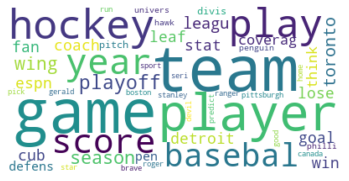



{'thier': 0.00016796727, 'decim': 0.00016756041, 'tablet': 0.0001675261, 'dash': 0.00016752462, 'wallac': 0.00016744016, 'dutch': 0.0001671397, 'ucalgari': 0.00016626049, 'eugen': 0.00016605173, 'unlock': 0.00016586573, 'salmon': 0.00016575986, 'rodney': 0.00016547437, 'bridg': 0.00016544928, 'passion': 0.00016543997, 'inhal': 0.00016540673, 'talon': 0.00016540663, 'livingston': 0.0001651588, 'dens': 0.000165082, 'deepli': 0.00016506259, 'parker': 0.00016501987, 'euro': 0.00016496285, 'anthoni': 0.00016493592, 'drum': 0.00016482567, 'southwestern': 0.00016475217, 'unfair': 0.00016470495, 'acn': 0.00016459778, 'berri': 0.00016459175, 'beginn': 0.00016458605, 'vladimir': 0.0001645347, 'buddi': 0.00016452777, 'flip': 0.0001644715, 'dictat': 0.00016433549, 'ward': 0.0001641946, 'mississippi': 0.00016417158, 'bernoulli': 0.00016416011, 'jackson': 0.00016412586, 'lay': 0.00016408772, 'vega': 0.00016407899, 'nigel': 0.00016407653, 'lobbi': 0.00016406078, 'walter': 0.00016402734, 'hunter': 0

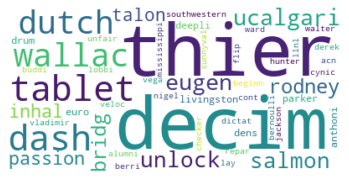



{'israel': 0.0033993179, 'govern': 0.0032311203, 'peopl': 0.0031664078, 'isra': 0.0029616747, 'clinton': 0.002393474, 'state': 0.0023875996, 'right': 0.0023432707, 'gun': 0.0020276941, 'weapon': 0.0020206247, 'kill': 0.0019435076, 'arab': 0.0019021904, 'dont': 0.0018489732, 'jew': 0.0018252784, 'think': 0.0017668759, 'armenian': 0.0017338899, 'articl': 0.0016899165, 'countri': 0.001666221, 'public': 0.0016446551, 'american': 0.0016377859, 'say': 0.0016085454, 'turkish': 0.0015807984, 'crimin': 0.0015310578, 'like': 0.0015194821, 'homosexu': 0.0014853936, 'time': 0.0014604484, 'crime': 0.0014482896, 'go': 0.0014019716, 'presid': 0.0013506198, 'citizen': 0.0013482617, 'nation': 0.0013425186, 'person': 0.0013419236, 'want': 0.0013181688, 'drug': 0.0013099036, 'greek': 0.0013040813, 'murder': 0.0012937577, 'polit': 0.0012741993, 'batf': 0.0012729568, 'legal': 0.0012651482, 'year': 0.0012642727, 'know': 0.0012530423, 'happen': 0.0012463899, 'fact': 0.0012337061, 'support': 0.0012322599, '

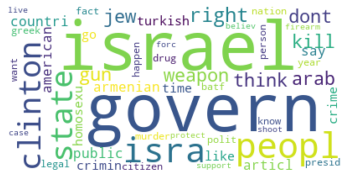



Fitting Time: 2.719998836517334


In [46]:
topic = 0  
start4 = time()
while topic < 9:
    topic_words_freq = dict(lda_model_tfidf_best.show_topic(topic, topn=50)) 
    print(topic_words_freq)
    topic += 1

    wordcloud = WordCloud(background_color="white").generate_from_frequencies(topic_words_freq) 
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    print('\n')
end4 = time()
print('Fitting Time:', end4 - start4)

## Finding the keywords and highest topic weight of each document

In [48]:
df_final.head(15)

,Doc_No,Highest_Topic,Highest_Topic_Weight,Keywords,Message
0,0,4.0,0.7684,"christian, peopl, think, bike, space, jesus, a...",From: (wheres my thing) Subject: WHAT car is t...
1,1,5.0,0.7776,"window, card, thank, file, drive, driver, mail...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,5.0,0.6458,"window, card, thank, file, drive, driver, mail...",From: (Thomas E Willis) Subject: PB questions....
3,3,5.0,0.7559,"window, card, thank, file, drive, driver, mail...",From: (Joe Green) Subject: Re: Weitek P9000 ? ...
4,4,4.0,0.7894,"christian, peopl, think, bike, space, jesus, a...",From: (Jonathan McDowell) Subject: Re: Shuttle...
5,5,9.0,0.8018,"israel, govern, peopl, isra, clinton, state, r...",From: (Foxvog Douglas) Subject: Re: Rewording ...
6,6,5.0,0.4162,"window, card, thank, file, drive, driver, mail...",From: (brian manning delaney) Subject: Brain T...
7,7,5.0,0.7209,"window, card, thank, file, drive, driver, mail...",From: (GRUBB) Subject: Re: IDE vs SCSI Organiz...
8,8,5.0,0.6486,"window, card, thank, file, drive, driver, mail...",From: Subject: WIn 3.0 ICON HELP PLEASE! Organ...
9,9,5.0,0.7764,"window, card, thank, file, drive, driver, mail...",From: (Stan Kerr) Subject: Re: Sigma Designs D...


In [49]:
documents[documents['index'] == 8545].values[0][0]

'From: (Mr. Someone) Subject: modem question Article-I.D.: blue.9061 Organization: pre-EE Lines: 2 art '

In [53]:
# Finding the top topic in each sentence
max_contribution_list = []
for i in range(1,9+1,1):
  print(i)
  max_contribution = df_final[df_final.Highest_Topic ==i].Highest_Topic_Weight.max()
  print(max_contribution)
  max_contribution_list.append(df_final[(df_final.Highest_Topic ==i) & (df_final.Highest_Topic_Weight ==max_contribution)])

pd.concat(max_contribution_list)

1
0.7409999966621399
2
0.820900022983551
3
nan
4
0.9153000116348267
5
0.9190999865531921
6
0.6398000121116638
7
0.9146999716758728
8
nan
9
0.9090999960899353


,Doc_No,Highest_Topic,Highest_Topic_Weight,Keywords,Message
8899,8899,1.0,0.7410,"gordon, bank, chastiti, shame, surrend, intell...",From: (Gordon Banks) Subject: Re: Medication F...
9850,9850,2.0,0.8209,"encrypt, clipper, chip, escrow, key, crypto, s...",From: (Vesselin Bontchev) Subject: Re: Secret ...
10836,10836,4.0,0.9153,"christian, peopl, think, bike, space, jesus, a...",From: mathew Subject: Alt.Atheism FAQ: Frequen...
6719,6719,5.0,0.9191,"window, card, thank, file, drive, driver, mail...",From: (Nick C. Fotis) Subject: (17 Apr 93) Com...
1541,1541,6.0,0.6398,"cliff, sunris, sunset, dakota, roman, south, s...",Subject: roman 02/14 From: (Cliff) Reply-To: (...
9635,9635,7.0,0.9147,"team, game, player, hockey, play, year, score,...",From: (Mitch McGowan) Subject: rec.sport.hocke...
9623,9623,9.0,0.9091,"israel, govern, peopl, isra, clinton, state, r...",From: (David Davidian) Subject: Accounts of An...


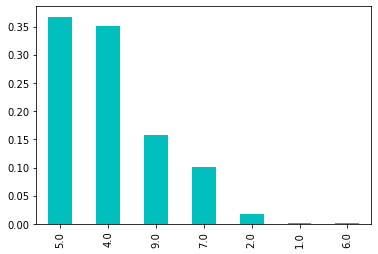

In [54]:
df_final.Highest_Topic.value_counts(normalize = True).plot(kind = 'bar', color = 'c')

###### Testing on out-of-sample document

In [56]:
document_test = 'I delete all the info from my harddisk which was storing the pictures of my favorite nba player and the space'
bow_vector_test = dictionary.doc2bow(preprocess(document_test))

for index, score in sorted(lda_model_tfidf_best[bow_vector_test], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model_tfidf_best.print_topic(index, 10)))

Score: 0.727790117263794	 Topic: 0.006*"window" + 0.004*"card" + 0.004*"thank" + 0.004*"file" + 0.003*"drive" + 0.003*"driver" + 0.003*"mail" + 0.003*"sale" + 0.003*"need" + 0.003*"graphic"
Score: 0.12836630642414093	 Topic: 0.008*"team" + 0.008*"game" + 0.005*"player" + 0.005*"hockey" + 0.004*"play" + 0.003*"year" + 0.003*"score" + 0.003*"basebal" + 0.003*"playoff" + 0.003*"season"
Score: 0.020881136879324913	 Topic: 0.003*"christian" + 0.002*"peopl" + 0.002*"think" + 0.002*"bike" + 0.002*"space" + 0.002*"jesus" + 0.002*"articl" + 0.002*"like" + 0.002*"say" + 0.002*"dont"
Score: 0.020548494532704353	 Topic: 0.003*"israel" + 0.003*"govern" + 0.003*"peopl" + 0.003*"isra" + 0.002*"clinton" + 0.002*"state" + 0.002*"right" + 0.002*"gun" + 0.002*"weapon" + 0.002*"kill"
Score: 0.020486777648329735	 Topic: 0.000*"thier" + 0.000*"decim" + 0.000*"dash" + 0.000*"tablet" + 0.000*"wallac" + 0.000*"dutch" + 0.000*"ucalgari" + 0.000*"eugen" + 0.000*"unlock" + 0.000*"salmon"
Score: 0.0204867776483297